# Bitcoin Direction Prediction – Gradient Boosting
This notebook rebuilds the pipeline using gradient boosting to predict the next 5-minute direction (UP/DOWN).

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame


In [126]:
client = CryptoHistoricalDataClient()

start_date = datetime.now() - timedelta(days=60)
request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USD"],
    timeframe=TimeFrame.Minute,
    start=start_date,
)

btc_bars = client.get_crypto_bars(request_params)
raw_df = btc_bars.df.reset_index()
raw_df = raw_df[raw_df["symbol"] == "BTC/USD"].copy()

print(f"Rows: {len(raw_df):,}  |  "
      f"From: {raw_df['timestamp'].min()}  →  {raw_df['timestamp'].max()}")
raw_df.head()

Rows: 82,910  |  From: 2025-12-25 13:52:00+00:00  →  2026-02-23 12:50:00+00:00


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,BTC/USD,2025-12-25 13:52:00+00:00,87586.9770,87629.990,87586.9770,87612.9280,0.00000,0.0,87608.483500
1,BTC/USD,2025-12-25 13:53:00+00:00,87620.3950,87670.350,87565.9060,87597.3655,0.01561,4.0,87611.737865
2,BTC/USD,2025-12-25 13:54:00+00:00,87601.1000,87601.100,87576.7145,87585.7250,0.00000,0.0,87588.907250
3,BTC/USD,2025-12-25 13:55:00+00:00,87589.1715,87611.145,87577.4500,87607.4245,0.00000,0.0,87594.297500
4,BTC/USD,2025-12-25 13:56:00+00:00,87616.7700,87616.770,87591.2500,87591.2500,0.00000,0.0,87604.010000


# Feature Engineering

In [127]:
HORIZON_MIN = 5

features = [
    "return_1", "momentum_5", "momentum_10",
    "close_vs_ma5", "close_vs_ma10",
    "volatility_10", "rsi",
    "body", "upper_wick", "lower_wick",
    "volume", "volume_delta", "trade_count",
]

def build_features(df_in):
    df = df_in.copy()
    df = df.sort_values("timestamp").reset_index(drop=True)

    df["return_1"] = df["close"].pct_change()
    df["momentum_5"] = df["close"] - df["close"].shift(5)
    df["momentum_10"] = df["close"] - df["close"].shift(10)
    df["ma_5"] = df["close"].rolling(5).mean()
    df["ma_10"] = df["close"].rolling(10).mean()
    df["ma_20"] = df["close"].rolling(20).mean()
    df["close_vs_ma5"] = df["close"] - df["ma_5"]
    df["close_vs_ma10"] = df["close"] - df["ma_10"]
    df["volatility_10"] = df["return_1"].rolling(10).std()

    delta = df["close"].diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = (-delta.clip(upper=0)).rolling(14).mean()
    rs = gain / loss.replace(0, 1e-9)
    df["rsi"] = 100 - (100 / (1 + rs))

    df["body"] = df["close"] - df["open"]
    df["upper_wick"] = df["high"] - df[["close", "open"]].max(axis=1)
    df["lower_wick"] = df[["close", "open"]].min(axis=1) - df["low"]
    df["volume_delta"] = df["volume"].diff()

    df["target_5m"] = (df["close"].shift(-HORIZON_MIN) > df["close"]).astype(int)
    df = df.dropna().reset_index(drop=True)
    return df

df_model = build_features(raw_df)

X = df_model[features]
y = df_model["target_5m"]

split_idx = int(len(df_model) * 0.8)
X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

print(f"Dataset shape : {X.shape}")
print(f"Class balance : UP={y.mean():.2%}  DOWN={(1-y.mean()):.2%}")
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Dataset shape : (82891, 13)
Class balance : UP=50.05%  DOWN=49.95%
Train size: (66312, 13), Test size: (16579, 13)


# Model Training – Gradient Boosting

Accuracy : 0.5351
ROC AUC  : 0.5478

              precision    recall  f1-score   support

        DOWN       0.52      0.55      0.54      8086
          UP       0.55      0.52      0.53      8493

    accuracy                           0.54     16579
   macro avg       0.54      0.54      0.54     16579
weighted avg       0.54      0.54      0.54     16579



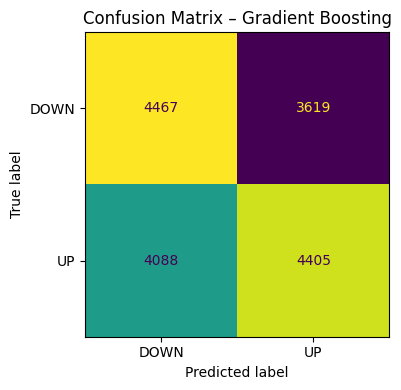

In [133]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, ConfusionMatrixDisplay,
    roc_auc_score
)

gb = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=6,
    max_iter=300,
    l2_regularization=0.0,
    random_state=42,
)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy : {acc:.4f}")
print(f"ROC AUC  : {auc:.4f}")
print()
print(classification_report(y_test, y_pred, target_names=["DOWN", "UP"]))

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["DOWN", "UP"], colorbar=False, ax=ax
)
ax.set_title("Confusion Matrix – Gradient Boosting")
plt.tight_layout()
plt.show()

# Prediction – Latest Row

In [ ]:
from datetime import datetime
import pytz

eastern = pytz.timezone('America/New_York')
now_et = datetime.now(eastern)
ts_snapped = now_et.replace(minute=(now_et.minute // 5) * 5, second=0, microsecond=0)

latest_feat = X.iloc[[-1]]
prob_up = float(gb.predict_proba(latest_feat)[0][1])
direction = "UP" if prob_up >= 0.5 else "DOWN"

print(f"Timestamp (NY, 5-min interval): {ts_snapped}")
print(f"Prediction: {direction}  (P(UP)={prob_up:.1%})")

Latest timestamp: 2026-02-23 12:50:00+00:00
Prediction: DOWN  (P(UP)=49.5%)


# Prediction – Manual Price Override (Optional)

In [141]:
from datetime import datetime
import pytz

input_price = 66340.42  # set to a float to override the latest close

# Get current time in NY, snapped to 5-min interval
eastern = pytz.timezone('America/New_York')
now_et = datetime.now(eastern)
ts_snapped = now_et.replace(minute=(now_et.minute // 5) * 5, second=0, microsecond=0)

if input_price is None:
    feat_row = X.iloc[[-1]]
else:
    tmp = raw_df.copy()
    tmp = tmp.sort_values("timestamp").reset_index(drop=True)
    tmp.loc[tmp.index[-1], ["close", "open", "high", "low"]] = input_price
    tmp_feat = build_features(tmp)
    feat_row = tmp_feat[features].iloc[[-1]]

prob_up = float(gb.predict_proba(feat_row)[0][1])
direction = "UP" if prob_up >= 0.5 else "DOWN"

print(f"Timestamp (NY, 5-min interval): {ts_snapped}")
print(f"Prediction: {direction}  (P(UP)={prob_up:.1%})")

Timestamp (NY, 5-min interval): 2026-02-23 07:55:00-05:00
Prediction: UP  (P(UP)=52.8%)
